# Projeto Final de Sistemas de Recuperação de Informação - Relatório
* **Nome:** Amanda de Mendonça Perez
* **Matrícula:** 211708002

## Introdução

Este projeto tem como principal objetivo implementar ideias introduzidas no curso de Sistemas de Recuperação de Informação, do programa de mestrado em Modelagem Matemática da FGV/EMAp. Nesse sentido, foi orientado que o trabalho apresentado deveria ter tema livre, sendo contruído a partir de um corpus de escolha livre sobre o qual pudessem ser aplicados os conceitos vistos em aula. Tendo isso em vista, o objetivo escolhido para esse projeto foi de construir e treinar um modelo capaz de fazer classificações de textos, lidando com múltiplas categorias. O processo seguido para a realização do trabalho está descrito a seguir.

---

## Escolha do corpus

Em um primeiro momento, pensou-se em utilizar o dataset ``ag_news_subset``, da biblioteca TensorFlow, que contém trechos de notícias (em inglês) e suas classificações segundo assunto (por exemplo, "esportes", "ciência e tecnologia", etc.). Contudo, apesar de o corpus apresentar uma grande quantidade de notícias, seus textos não estavam apresentados na íntegra, mas sim apenas resumos de poucas linhas da notícia. Em decorrência disso, optei por buscar outra base de dados que permitisse trabalhar com um problema semelhante: realizar uma classificação textual multiclasse.

O novo problema encontrado foi realizar uma classificação de letras de música segundo gênero. Como não foi encontrado nenhum corpus variado e grande o suficiente sobre o assunto, optou-se por realizar um web scrapping, coletando letras de músicas do site [Letras.mus](https://www.letras.mus.br/) utilizando a biblioteca BeautifulSoup. A princípio, foi utilizada como base uma lista de url's que redirecionam para as páginas de diversos artistas presentes no site, que pode ser encontrada em https://github.com/vaaaltin/PLN/blob/master/Trabalho_2/artistas.txt. A partir disso, o código construído objetivava passar por todas as músicas de todos esses artistas a fim de gerar um corpus vasto o suficiente para que fossem realizadas boas análises. Entretanto, como a lista misturava artistas de diferentes idiomas e o script estava demorando muito para terminar de rodar (algumas horas para chegar quase a metade), optei por excluir manualmente artistas que não fossem de língua portuguesa. Essa primeira abordagem ao problema de construção do corpus pode ser encontrada no arquivo ``main.py`` e o resultado parcial em ``musicas.txt``, ambos na pasta *data*. 

Além dos problemas já citados, essa abordagem também dificultou a obtenção do gênero de cada música, uma vez que o html do site não continha essa informação de maneira muito clara para todos os artistas. Tendo isso em vista, foram selecionados apenas 49 artistas de língua inglesa cujo gênero musical pudesse ser encontrado no site Letras.mus, e foi criado o arquivo ``dataset.csv`` contendo os links para as páginas dos artistas selecionados e o gênero de suas músicas (que foram anotados manualmente). A partir desse novo conjunto de url's, foi feito um novo script (``dataset.py``), que realizou novamente o web scrapping, gerando o arquivo ``musicas_short.txt``, que já contém as categorias de cada música. O novo dataset contém 9340 músicas de 14 gêneros distintos e, desta vez, não demorou tanto tempo para ser gerado (apenas cerca de 30 minutos). Logo, optou-se por utilizá-lo como corpus escolhido para a realização do projeto.

---

## Implementação

Primeiramente, foi necessário realizar os imports de todos os módulos e bibliotecas utilizadas. Além disso, foram já definidas algumas constantes. As principais bibliotecas utilizadas foram pandas, numpy, nltk, scikit learn e gensim (ao qual pertence o Word2Vec), bem como algumas bibliotecas auxiliares, como matplotlib, seaborn, etc.


In [83]:
# imports
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random

from nltk.corpus import stopwords
from pathlib import Path
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import EnglishStemmer
from gensim.models import Word2Vec as w2v
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, classification_report, roc_auc_score, roc_curve, auc
from collections import defaultdict
from itertools import cycle


# constantes
ROOT = Path().absolute()
txt_mus = open(ROOT/"data/musicas_short.txt", "r", encoding='utf-8')
lyrics = txt_mus.read()
sw = stopwords.words('english')
plt.style.use('ggplot')

Em seguida, lendo o arquivo e armazenando as músicas e seus metadados em uma lista:

In [2]:
# Lendo o arquivo de texto
songs_list = lyrics.split("\n\nXXXXXXXXXX\n\n")
songs_list.pop()

all_lyrics = []
for song in songs_list:
    lyrics1 = song.split("\n---\n")
    lyrics = lyrics1[0].split("\n>> ") + [lyrics1[1]]
    all_lyrics.append(lyrics)

In [7]:
# verificando a lista criada:
all_lyrics[9151:9153]

[['Nervous',
  'indie',
  "Maybe I shouldn't try to be perfect\nI confess, I'm obsessed with the surface\nIn the end, if I fall or if I get it all\nI just hope that it's worth it\n\nLast year I fell flat on my face\nAnd last month I knew somethin' should change\nLast week I started over again\nAsk me and I'll tell you how I've been\nMhm, don't get me started\n\nYou got me nervous to speak\nSo I just won't say anything at all\nI've got an urge to release\nAnd you keep tell me to hold on\nYou got me nervous to move\nSo I just won't give anything to you\nYou got me turnin' all around to be who you need me to\n\nShould I be quiet?\nCome on, be silent\nYou know I'm tryin'\nSo don't say nothin'\n\nTell me you trust me and\nKiss me and hug me, yeah\nI would do anything for ya\nYou just gotta love me and\n\nI got an itch in my throat\nI don't know which way to go\nI keep on switchin', I know\nI need a different approach\nIt's all because I wanna\nShow you that I'm so capable\n\nYou got me nerv

Em seguida, foi necessário limpar e tokenizar os textos. O resultado obtido foi armazenado em um DataFrame.

In [29]:
# Limpando e tokenizando os textos
swu = stopwords.words('english') + list(string.punctuation)
stemmer = EnglishStemmer()

clean_lyrics = {'titulo': [], 'titulo tokenizado':[], 'musica completa':[], 'musica':[], 'genero':[]}
tokenizador = WordPunctTokenizer()

for song in all_lyrics:
    current_song = []
    current_title = []
    song_lower = song[2].lower()
    title_lower = song[0].lower()
    genre = song[1]
    for token in tokenizador.tokenize(song_lower):
        if (token not in swu):
            current_song.append(stemmer.stem(token))
    for token in tokenizador.tokenize(title_lower):
        if (token not in list(string.punctuation)):
            # Inclui apenas pontuação porque, como os títulos tendem a ter
            # menos palavras (e, muitas delas, stopwords), perde-se muita
            # informação ao excluir as stopwords.
            current_title.append(stemmer.stem(token))
    clean_lyrics['titulo'].append(title_lower)
    clean_lyrics['titulo tokenizado'].append(current_title)
    clean_lyrics['musica completa'].append(song[2])
    clean_lyrics['musica'].append(current_song)
    clean_lyrics['genero'].append(genre)

lyrics_df = pd.DataFrame(data = clean_lyrics)
lyrics_df.head()

,titulo,titulo tokenizado,musica completa,musica,genero
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop


Observe que, no código acima, optou-se por não exluir as stopwords dos títulos. A razão para isso é que, em uma primeira análise que descartou as stopwords, verificou-se que alguns título simplesmente não apresentavam mais nenhum token, pois eram compostos exclusivamente de stopwords (por exemplo, a música "who am i"). De fato, como são poucas palavras que estão presentes no título, mesmo stopwords trazem alguma informação sobre a música, de modo que faria sentido manter esses tokens ao limpar os textos. Em um sistema de recuperação de letras de música, por exemplo, seria razoável manter essa informação pois uma busca baseada no título da música poderia não ser bem sucedida se essas stopwords fossem descartadas. 

A partir do DataFrame acima, foram em seguida analisados os diferentes gêneros musicais nele presentes:

In [30]:
lyrics_df['genero'].unique()

array(['pop', 'soul', 'indie', 'eletronica', 'pop rock', 'rock and roll',
       'hard rock', 'reggae', 'heavy metal', 'gospel', 'hip hop/rap',
       'punk rock', 'alternativo', 'folk'], dtype=object)

In [31]:
lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False)

genero
pop rock         1345
rock and roll    1310
pop              1259
gospel            965
eletronica        902
heavy metal       718
hip hop/rap       698
indie             642
hard rock         461
alternativo       319
punk rock         295
reggae            217
soul              162
folk               47
Name: musica, dtype: int64

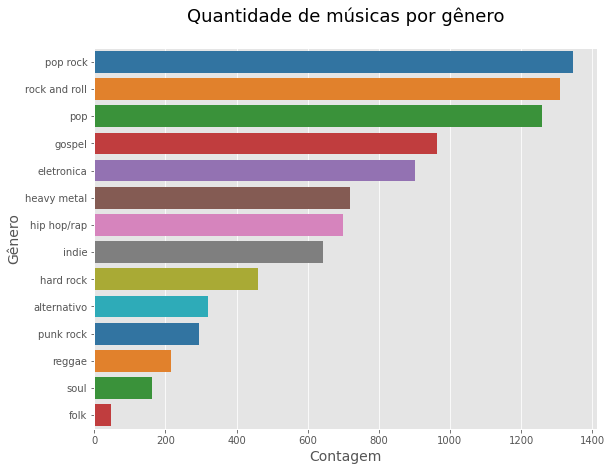

In [32]:
# Visualizando os dados acima
target = lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False).index
count = lyrics_df.groupby('genero').count()['musica'].sort_values(ascending=False).values

plt.figure(figsize = (9, 7))
sns.barplot(x=count, y=target, palette='tab10')
plt.xlabel('Contagem', size=14)
plt.ylabel('Gênero', size=14)
plt.title('Quantidade de músicas por gênero\n', size=18)
plt.show()

### Tentativa de reorganizar as classificações e diminuir a quantidade de classes existentes

Da breve análise realizada acima, pode-se notar que existem muitas classes a serem consideradas no modelo de classificação, e muitas delas são bem semelhantes entre si e/ou apresentam muito poucas ocorrências no dataset. Considerando essas observações, optou-se por fazer uma reorganização dos dados a fim de dimunuir o número de categorias e facilitar as análises.

Para essa reorganização, foram primeiramente excluídos alguns gêneros com menos ocorrências e/ou menos informação contida nas letras (por exemplo, músicas eletrônicas, que em geral têm menos texto e são caracterizadas principalmente pelo ritmo e fatores que independem da letra). Além disso, músicas de gêneros que não conseguiram ser facilmente encaixados nas categorias criadas mais abaixo também foram descartados. Logo, foram excluídas as seguintes categorias:
* eletrônica
* reggae
* heavy metal
* punk rock
* soul

Em seguida, alguns gêneros semelhantes foram reunidos sob uma mesma categoria. Utiliazndo inteiros de 0 a 5, os gêneros presentes na tabela foram reagrupados da seguinte forma:
* pop, pop rock -> pop (0)
* rock and roll, hard rock -> rock (1)
* indie, alternativo, folk -> indie/alternativo (2)
* hip hop/rap -> hip hop/rap (3)
* gospel -> gospel (4)
* eletronica, reggae, heavy metal, punk rock, soul -> excluídos do dataframe (5)

Aplicando a nova categorização:


In [33]:
dicio_target = {'pop':0, 'soul':5, 'indie':2, 'eletronica':5, 'pop rock':0, 'rock and roll':1,\
                'hard rock':1, 'reggae':5, 'heavy metal':5, 'gospel':4, 'hip hop/rap':3,\
                'punk rock':5, 'alternativo':2, 'folk':2}

lyrics_df['Target'] = lyrics_df.apply(lambda x: dicio_target[x['genero']], axis=1)
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
9335,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
9336,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
9337,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
9338,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


In [34]:
# Excluindo a categoria 5
lyrics_df = lyrics_df.loc[lyrics_df['Target'] != 5].reset_index().drop(columns='index')
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
7041,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
7042,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
7043,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
7044,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


### Breve análise exploratória dos dados

Utilizando o dataset já limpo e recategorizado, foram construídos alguns gráficos a fim explorar as principais características dos dados. Esses dados também foram analisados no arquivo ``teste.ipynb``, onde foram obtidos alguns resultados interessantes que serão citados posteriormente neste relatório. Contudo, apenas as principais análises foram reproduzidas neste notebook atual.


In [21]:
count_df = lyrics_df.groupby('Target').count()
count_df = count_df['musica'].sort_values(ascending=False)
count_df.index

Int64Index([0, 1, 2, 4, 3], dtype='int64', name='Target')

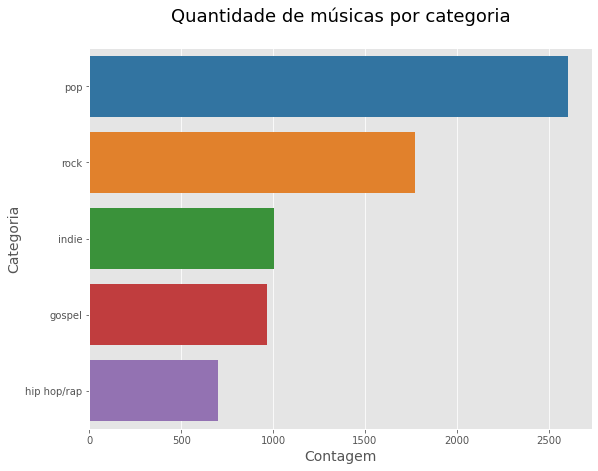

In [22]:
dicio_target = {0: 'pop',1:'rock',2:'indie', 3:'hip hop/rap', 4:'gospel'}
target_int = count_df.index
target = [dicio_target[idx] for idx in target_int.tolist()]
count = count_df.values

plt.figure(figsize = (9, 7))
sns.barplot(x=count, y=target, palette='tab10')
plt.xlabel('Contagem', size=14)
plt.ylabel('Categoria', size=14)
plt.title('Quantidade de músicas por categoria\n', size=18)
plt.show()

Note que, agora, todas as categorias restantes do corpus têm mais de 500 músicas cada, o que pode ser positivo para o treinamento do modelo.

### Brincando com os modelos do Word2Vec

A abordagem escolhida para realizar classificações automáticas foi a seguinte: utilizando os modelos do Word2Vec, da biblioteca gensim, cada palavra presente no dataset seria vetorizada (assim, teríamos apenas dados numéricos com os quais trabalhar) e, a partir disso, poderia ser feita uma regressão logística, treinada sobre os dados, que pudesse classificar novas músicas. Dessa forma, antes de implementar o modelo de fato, busquei testar os modelos do Word2Vec, verificando similaridade entre palavras. Os testes realizados estão apresentados a seguir:


In [35]:
titles_list =  lyrics_df['titulo tokenizado'].tolist()
lyrics_list = lyrics_df['musica'].tolist()

In [36]:
titles_model = w2v(titles_list, min_count=5)
lyrics_model = w2v(lyrics_list, min_count=25)

def similar(word, where=1):
    if where == 0:  # considera o título das músicas
        similar = titles_model.wv.most_similar(stemmer.stem(word))
    elif where == 1:  # considera a letra das músicas
        similar = lyrics_model.wv.most_similar(stemmer.stem(word))
    return similar

In [38]:
similar('love', where = 0)

[('you', 0.9993304014205933),
 ('feat', 0.9993242621421814),
 ('i', 0.9991956353187561),
 ('amp', 0.9991948008537292),
 ('this', 0.9991876482963562),
 ('the', 0.9991825222969055),
 ('a', 0.9991616606712341),
 ('my', 0.9991461038589478),
 ('to', 0.9991381168365479),
 ('s', 0.9991151690483093)]

In [40]:
similar('talk', where = 0)

[('fire', 0.9945343732833862),
 ('you', 0.9944453835487366),
 ('my', 0.9944217205047607),
 ('remix', 0.9944202899932861),
 ('with', 0.9942560195922852),
 ('feat', 0.9941890835762024),
 ('i', 0.9941650629043579),
 ('version', 0.9941440224647522),
 ('love', 0.9940650463104248),
 ('want', 0.994059681892395)]

Nota-se acima que a vetorização aplicada sobre os títulos parece não fornecer muita informação sobre as palavras, possivelmente devido à escolha de manter as stopwords. Contudo, utilizando as letras das músicas em si:


In [39]:
similar('love')

[('fail', 0.5785202383995056),
 ('overwhelm', 0.5121670365333557),
 ('lust', 0.5085773468017578),
 ('true', 0.508439302444458),
 ('modern', 0.49952781200408936),
 ('everlast', 0.49849531054496765),
 ('kind', 0.49648770689964294),
 ('darl', 0.48521867394447327),
 ('rescu', 0.4701109528541565),
 ('grace', 0.466376394033432)]

In [41]:
similar('talk')

[('languag', 0.6126261949539185),
 ('tough', 0.5107820630073547),
 ('walk', 0.48812830448150635),
 ('talkin', 0.4688379466533661),
 ('listen', 0.466368705034256),
 ('relat', 0.4490041732788086),
 ('hush', 0.4480576515197754),
 ('marri', 0.441238671541214),
 ('curv', 0.4387700855731964),
 ('chat', 0.4383745789527893)]

In [42]:
similar('money')

[('spend', 0.648094654083252),
 ('earn', 0.6321666836738586),
 ('bill', 0.6133579611778259),
 ('cash', 0.6060277819633484),
 ('dolla', 0.594891369342804),
 ('rent', 0.5896739959716797),
 ('makin', 0.5799252986907959),
 ('pay', 0.5627021193504333),
 ('dindu', 0.5571467876434326),
 ('dollar', 0.5487162470817566)]

In [43]:
similar('dead')

[('buri', 0.6868449449539185),
 ('woke', 0.5424138307571411),
 ('headlin', 0.5126634836196899),
 ('death', 0.5008767247200012),
 ('led', 0.49564191699028015),
 ('bed', 0.4949278235435486),
 ('soon', 0.47804251313209534),
 ('arriv', 0.4777282476425171),
 ('awak', 0.4708567261695862),
 ('head', 0.4675960838794708)]

In [44]:
similar('god')

[('bless', 0.868298351764679),
 ('almighti', 0.7874808311462402),
 ('emmanuel', 0.6627007126808167),
 ('reign', 0.6626602411270142),
 ('majesti', 0.6372019052505493),
 ('mighti', 0.6359822750091553),
 ('righteous', 0.6320130825042725),
 ('overcom', 0.6234685182571411),
 ('exalt', 0.6192553043365479),
 ('declar', 0.6185216307640076)]

As palavras semelhantes retornadas pelo modelo aparentam ter de fato alguma relação com a palavra de cada query, indicando que o modelo de vetorização do Word2Vec parece ter se ajustado bem ao corpus utilizado. Contudo, nota-se que o primeiro caso verificado (palavra "love") aparenta retornar muitas palavras não tão relacionadas entre si. Uma possível explicação é o fato de "love" ser altamente recorrente em todos os gêneros do dataset. 

No notebook de teste, no qual foi feita uma exploração inicial dos dados, verficou-se que justamente "love" é uma das palavras mais recorrentes em cada um dos gêneros, sendo a primeira mais frequente em boa parte deles. Isso pode implicar uma variedade significados atribuídos à palavra e uma variedade de contextos nos quais ela é utilizado, levando associações não tão relacionadas entre si.


### Usando Word2Vec para fazer a classificação

Por fim, a partir do modelo de vetorização explorado acima, foram treinados dois modelos que se utilizam de regressão logística para lidar com a classifição das músicas. Primeiramente, os dados foram separados em conjunto de treinamento e teste, utilizando uma proporção de 70% e 30% para cada conjunto, respectivamente.


In [45]:
# Separando conjunto de treinamento e de teste:
X_train, X_test, y_train, y_test = train_test_split(lyrics_df['musica'], lyrics_df['Target'], test_size=0.3, shuffle=True)

Verificando a "aparência" dos conjuntos obtidos:

In [46]:
X_train 

1767    [doubt, must, love, one, littl, kiss, feel, gl...
5952    [sing, everyth, alway, tell, world, everyth, d...
5245    [young, girl, leyt, dress, hand, down, scrub, ...
5581    [let, repeat, non, conformist, oath, promis, d...
2154    [feel, good, babi, feel, good, babi, caus, bra...
                              ...                        
6241    [melt, hardest, heart, speak, life, soul, spin...
3106    [california, queen, caffein, smile, look, eye,...
1948    [care, spent, dough, night, gonna, gonna, rock...
6178    [let, say, much, love, let, speak, merci, grac...
2294    [diamond, ring, wear, hand, gonna, tell, world...
Name: musica, Length: 4932, dtype: object

In [47]:
y_train 

1767    1
5952    4
5245    2
5581    2
2154    0
       ..
6241    4
3106    0
1948    1
6178    4
2294    1
Name: Target, Length: 4932, dtype: int64

Em seguida, vetorizando as palavras de cada música e, assim, tornando o dataset compatível com o formato utilizado pelos modelos do scikit learn:

In [48]:
# Deixando os dados no formato necessário para a aplicação dos modelos do scikit learn
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        '''
        Transforma os dados textuais em dados numéricos, vetorizando as palavras
        de cada música.
        '''
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] \
            or [np.zeros(self.dim)], axis=0) for words in X])

model = w2v(lyrics_df['musica'], min_count=1)
w2vec = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2vec)
X_train_ = modelw.transform(X_train)
X_test_ = modelw.transform(X_test)

Verificando o novo conjunto de treinamento:

In [49]:
X_train_ 

array([[ 0.05881164, -0.18864904,  0.10373628, ..., -0.26071638,
        -0.55475259,  0.11826897],
       [-0.35326159,  0.075444  ,  0.6349746 , ..., -0.60220677,
        -0.53874356,  0.53071165],
       [ 0.1225083 ,  0.01182796, -0.12874581, ..., -0.15329836,
        -0.4445301 ,  0.12467494],
       ...,
       [ 0.24339695, -0.20853482,  0.32600909, ..., -0.59256649,
         0.08867235, -0.34103894],
       [ 0.05351052, -0.0009377 ,  0.68615288, ..., -0.57092041,
        -0.41798797,  0.35612881],
       [-0.12282274,  0.04957513,  0.41302931, ..., -0.33576927,
        -0.38705555, -0.18874337]])

Após preparar os dados, resta agora treinar os modelos. Para tanto, foi utilizada a biblioteca scikit learn, que já fornace modelos prontos e fáceis de serem aplicados sobre os dados. Como estamos lidando com dados categóricos, o modelo de regressão logística foi escolhido para tratar o problema. Além disso, por estarmos lidando com múltiplas classes (mais especificamente, 5), foi necessário utilizar como solver alguma alternativa capaz de tratar problemas multiclasse. No caso, foi escolhido o solver "newton-cg".

Os modelos do scikit learn permitem ainda utilizar outros argumentos, porém boa parte deles foram apenas utilizados segundo o padrão da própria biblioteca. Entretanto, o argumento ``class_weight`` se mostrou promissor em ser passado um valor próprio, pois permite que sejam atribuídos pesos para as classes. Nesse sentido, foram treinados dois modelos: o primeiro (``regressao_modelo1``) leva em consideração a diferença no número de ocorrências
dentro de cada classe, atribuindo pesos distintos para cada categoria a depender desse valor; já o segundo modelo (``regressao_modelo2``)
não o faz, utilizando peso 1 para todas as categorias, conforme o padrão do scikit learn.

Assim, treinando os modelos propostos:

In [51]:
# Definindo os modelos:
regressao_modelo1 = LogisticRegression(solver = 'newton-cg', class_weight='balanced')
regressao_modelo2 = LogisticRegression(solver = 'newton-cg')
# Treinando os modelos:
regressao_modelo1.fit(X_train_, y_train)
regressao_modelo2.fit(X_train_, y_train)

LogisticRegression(solver='newton-cg')

Utilizando os modelos treinados para fazer predições sobre o conjunto de teste:

In [52]:
y_pred1 = regressao_modelo1.predict(X_test_)
y_pred2 = regressao_modelo2.predict(X_test_)


---

## Avaliando os modelos

Finalmente, utilizando as métricas disponibilizadas pelo scikit learn, podemos comparar os dois modelos e verificar o quão bons foram os resultados obtidos.


In [53]:
print('>> Modelo 1 (considerando diferença no tamanho das classes):\n\n', classification_report(y_test, y_pred1), \
    '\n---\n', '\n>> Modelo 2 (não considerando diferença no tamanho das classes):\n\n', classification_report(y_test, y_pred2))

>> Modelo 1 (considerando diferença no tamanho das classes):

               precision    recall  f1-score   support

           0       0.61      0.34      0.44       782
           1       0.52      0.50      0.51       519
           2       0.29      0.46      0.35       312
           3       0.47      0.79      0.59       207
           4       0.83      0.93      0.88       294

    accuracy                           0.52      2114
   macro avg       0.54      0.60      0.55      2114
weighted avg       0.56      0.52      0.52      2114
 
---
 
>> Modelo 2 (não considerando diferença no tamanho das classes):

               precision    recall  f1-score   support

           0       0.52      0.68      0.59       782
           1       0.50      0.49      0.50       519
           2       0.31      0.11      0.16       312
           3       0.67      0.57      0.61       207
           4       0.88      0.87      0.87       294

    accuracy                           0.57     

Segundo modelo: recall bem baixo -> o modelo deixou passar muitas músicas da categoria indie/alternativa

Ambos os modelos foram piores para lidar com a categoria indie/alternativa, foram melhores (porém ainda ruins) para lidar com as categorias
pop, rock e hip hop/rap, mas apresentaram ótimos resultados lidando com a categoria gospel.

### Roc curve

In [56]:
# Calculando as probabilidades de cada música pertencer a um gênero ou outro
y_score1 = regressao_modelo1.predict_proba(X_test_)
y_score2 = regressao_modelo2.predict_proba(X_test_)
y_score1

array([[5.65751039e-01, 2.62246612e-01, 1.66846859e-01, 4.00963088e-03,
        1.14585870e-03],
       [5.95935674e-01, 1.08866621e-01, 2.86862503e-01, 8.23516042e-03,
        1.00041978e-04],
       [2.92979305e-01, 5.92463540e-02, 1.97008569e-01, 4.49813161e-01,
        9.52611104e-04],
       ...,
       [2.84356983e-01, 3.35684430e-01, 1.08980840e-01, 2.70281600e-01,
        6.96145983e-04],
       [6.02228953e-02, 6.05769864e-02, 9.23144832e-02, 2.02407574e-02,
        7.66644878e-01],
       [2.36806276e-01, 5.35564950e-01, 2.25454426e-01, 2.12605360e-03,
        4.82933802e-05]])

In [84]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_amostras, n_classes)

(2114, 5)

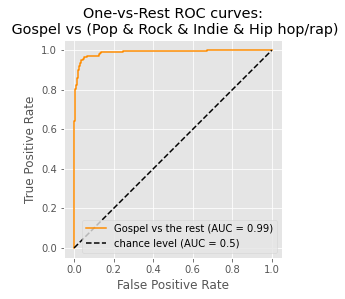

In [85]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 4],
    y_score1[:, 4],
    name=f"Gospel vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Gospel vs (Pop & Rock & Indie & Hip hop/rap)")
plt.legend()
plt.show()

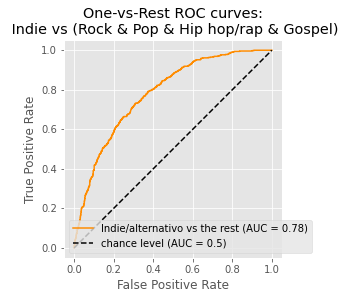

In [86]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 1],
    y_score2[:, 1],
    name=f"Indie/alternativo vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Indie vs (Rock & Pop & Hip hop/rap & Gospel)")
plt.legend()
plt.show()

#### Para o primeiro modelo:

In [87]:
fpr, tpr, roc_auc = dict(), dict(), dict()

# micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(5):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # interpolação linear

mean_tpr /= 5

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.82
Micro-averaged One-vs-Rest ROC AUC score:
0.84


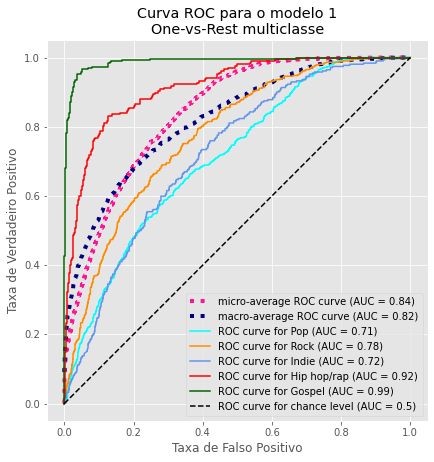

In [88]:
target_names = {0:'Pop', 1:'Rock', 2:'Indie', 3:'Hip hop/rap', 4:'Gospel'}

fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "darkgreen"])
for class_id, color in zip(range(0,5), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score1[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curva ROC para o modelo 1\nOne-vs-Rest multiclasse")
plt.legend()
plt.show()

#### Para o segundo modelo:

In [89]:
fpr, tpr, roc_auc = dict(), dict(), dict()

# micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(5):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # interpolação linear

mean_tpr /= 5

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.82
Micro-averaged One-vs-Rest ROC AUC score:
0.87


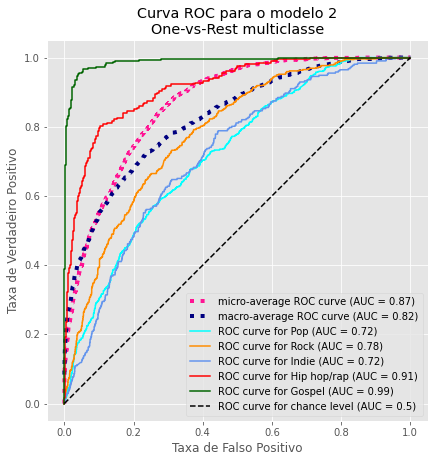

In [91]:
target_names = {0:'Pop', 1:'Rock', 2:'Indie', 3:'Hip hop/rap', 4:'Gospel'}

fig, ax = plt.subplots(figsize=(7, 7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "darkgreen"])
for class_id, color in zip(range(0,5), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score2[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curva ROC para o modelo 2\nOne-vs-Rest multiclasse")
plt.legend()
plt.show()

In [72]:
print(X_test)
print('\n')
print(y_test)

2037    [instant, karma, gonna, get, gonna, knock, rig...
2176    [know, somewher, somewher, far, away, want, ba...
1373    [stage, rockin, ',, stir, crazi, cocoa, flow, ...
6524    [see, color, world, rearrang, center, sentinel...
4935    [oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...
                              ...                        
6378    [espíritu, muévet, con, poder, fuego, ven, sop...
6695    [drug, drop, drop, drop, drop, bitch, get, dro...
2004    [friend, say, love, mean, lot, know, love, got...
5820    [love, enough, see, broken, heart, gain, brand...
2055    [would, think, sang, tune, would, stand, walk,...
Name: musica, Length: 2114, dtype: object


2037    1
2176    0
1373    0
6524    2
4935    0
       ..
6378    4
6695    3
2004    1
5820    4
2055    1
Name: Target, Length: 2114, dtype: int64


In [103]:
print(lyrics_df.iloc[3444]) # primeira música do conjunto de teste
print('\n')
print(f'Modelo 1: {y_pred1[0]}, Modelo 2: {y_pred2[0]}')

titulo                                                           bones
titulo tokenizado                                               [bone]
musica completa      The second you walked in the room, my legs sta...
musica               [second, walk, room, leg, start, shake, blood,...
genero                                                        pop rock
Target                                                               0
Name: 3444, dtype: object


Modelo 1: 0, Modelo 2: 0


No caso acima, podemos ver que ambos os modelos acertaram a previsão.

Por fim, testando com uma última música:

In [104]:
boss_final = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final['musica']

In [106]:
boss_final1 = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final1['musica']

modelo_teste = w2v(boss_final,min_count=1)
w2vec_teste = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw_teste = MeanEmbeddingVectorizer(w2vec_teste)
boss_final_ = modelw_teste.transform(boss_final)
boss_final_

array([[ 0.06629094, -0.03711534,  0.05951777, -0.28147966, -0.03757274,
        -0.46364433,  0.12307993,  0.41165465, -0.38287804, -0.544488  ,
        -0.25042218, -0.5088017 ,  0.31273386,  0.4291813 , -0.35255682,
         0.18168949,  0.22267887, -0.30262965, -0.4895625 , -0.33097106,
         0.08654214, -0.5066243 ,  0.00537932, -0.0386173 , -0.16988179,
         0.14773019, -0.6186023 , -0.33915007, -0.6300532 , -0.13404459,
         0.20835465,  0.26227346,  0.3603134 , -0.41073704,  0.14502   ,
         0.5304364 ,  0.33668327, -0.24228233, -0.41800037, -0.1571959 ,
        -0.40512118, -0.16028367, -0.5911089 ,  0.44954458,  0.2256311 ,
         0.11772861, -0.35365653, -0.13652313,  0.22157906,  0.38444117,
         0.29276535,  0.11603554, -0.4531159 , -0.21500343, -0.16652325,
         0.20627052,  0.13610134, -0.15291421,  0.11182084, -0.06971484,
         0.14189719, -0.42437902,  0.1926834 ,  0.10237315, -0.44677433,
         0.21487524,  0.36387095, -0.13594054, -0.1

In [110]:
regressao_modelo1.predict(boss_final_)  # Modelo que considera a quantidade de músicas por categoria

array([4, 1, 4], dtype=int64)

In [120]:
regressao_modelo2.predict(boss_final_)  # Modelo que não considera quantidade

array([0, 1, 0], dtype=int64)

In [115]:
boss_final1

,titulo,titulo tokenizado,musica completa,musica,genero,Target
3645,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",pop rock,0
4946,take me to church,"[take, me, to, church]","Yeah, yeah, yeah, yeah, yeah\nMy lover's got h...","[yeah, yeah, yeah, yeah, yeah, lover, got, hum...",pop,0
6476,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",alternativo,2


In [119]:
boss_final1.iloc[1]['musica completa']

"Yeah, yeah, yeah, yeah, yeah\nMy lover's got humour\nShe's the giggle at a funeral\nKnows everybody's disapproval\nI should've worshipped her sooner\n\nIf the heavens ever did speak\nShe is the last true mouthpiece\nEvery Sunday's getting more bleak\nA fresh poison each week\n\nWe were born sick\nBut I love it\nCommand me to be well\nAmen, amen, amen\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell you my sins\nSo you can sharpen your knife\nOffer me that deathless death\nGood God, let me give you my life\n\nIf I'm a pagan of the good times\nMy lover's the sunlight\nTo keep the goddess on my side\nShe demands a sacrifice\nThat looks tasty\nThat looks plenty\nThis is hungry work\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell you my sins\nSo you can sharpen your knife\nOffer me my deathless death\nGood God, let me give you my life\n\nTake me to church\nI'll worship like a dog at the shrine of your lies\nI'll tell yo

No caso acima, uma mesma música (regravada por artistas que tocam gêneros diferentes) resultou em classificações distintas pelo modelo treinado,
provavelmente devido a pequenas alterações na letra, como a presença do trecho "yeah, yeah, yeah" na segunda música.


---

## Discussão e conclusões

- Relação com sistemas de recuperação de informação: o modelo poderia ser utilizado para categorizar músicas automaticamente e facilitar buscas por gênero. Por exemplo, artistas menores costumam não ter categorização segundo gênero em sites de músicas (como o próprio Letras.mus), pois essa categorização é, em geral, feita manualmente. Essas classificações automáticas poderiam vir a ser utilizadas, por exemplo, para buscar músicas semelhantes a outras de gênero conhecido ou para facilitar a catalogação de novas músicas segundo o estilo.

- podia ter colocado o nome das artistas no corpus (pode ser útil no desenvolvimento de sistemas de recuparação e pesquisa)

- música alternativa/indie pode ter dado problema porque muitas vezes se assemelha a vários gêneros distintos (exemplo: twenty one pilots)

- o modelo ficou muito bom pra diferenciar música gospel de música não-gospel (possivelmente porque o vocabulário desse tipo de música é muito específico e )

- outro problema é que o gênero musical é muitas vezes definido por fatores externos a letra da música, como o ritmo: uma mesma música tocada em ritmos diferentes pode receber outras classificações. Assim, um possível trabalho posterior que poderia melhorar o resultado